<a href="https://colab.research.google.com/github/shahchayan9/Clustering/blob/main/Clustering_with_images_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Install Required Libraries
!pip install torch torchvision -q
!pip install transformers -q
!pip install matplotlib scikit-learn opencv-python -q


In [ ]:
# Step 2: Import Required Libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from transformers import CLIPProcessor, CLIPModel
import cv2
import urllib.request
import os

In [ ]:
# Step 3: Define Image URLs or Paths
# Replace or add valid URLs or use fallback images
image_urls = [
    "https://upload.wikimedia.org/wikipedia/commons/4/47/PNG_transparency_demonstration_1.png",
    "https://upload.wikimedia.org/wikipedia/commons/a/a9/Example.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/3/3f/JPEG_example_JPG_RIP_100.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/9/96/Example.png"
]

fallback_image_path = "/tmp/fallback.jpg"
# Generate a fallback image
if not os.path.exists(fallback_image_path):
    fallback_image = np.ones((224, 224, 3), dtype=np.uint8) * 255
    cv2.imwrite(fallback_image_path, fallback_image)

In [ ]:
# Step 4: Load Pretrained CLIP Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model.to(device)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [ ]:
# Step 5: Download and Preprocess Images
def preprocess_image(image_url):
    try:
        # Download the image
        local_path = "/tmp/" + image_url.split("/")[-1]
        urllib.request.urlretrieve(image_url, local_path)

        # Read and preprocess the image
        image = cv2.imread(local_path)
        if image is None:
            raise ValueError("Failed to load image")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    except Exception as e:
        print(f"Error loading {image_url}: {e}. Using fallback image.")
        # Return the fallback image in case of failure
        return cv2.imread(fallback_image_path)

# Preprocess all images
images = [preprocess_image(url) for url in image_urls]
inputs = processor(images=images, return_tensors="pt", padding=True)
inputs = {key: val.to(device) for key, val in inputs.items()}

Error loading https://upload.wikimedia.org/wikipedia/commons/3/3f/JPEG_example_JPG_RIP_100.jpg: HTTP Error 404: Not Found. Using fallback image.
Error loading https://upload.wikimedia.org/wikipedia/commons/9/96/Example.png: HTTP Error 404: Not Found. Using fallback image.


In [ ]:
# Step 6: Generate Image Embeddings
with torch.no_grad():
    embeddings = model.get_image_features(**inputs)
embeddings = embeddings.cpu().numpy()

In [ ]:
# Step 7: Perform Clustering
num_clusters = 2  # Adjust based on dataset
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)

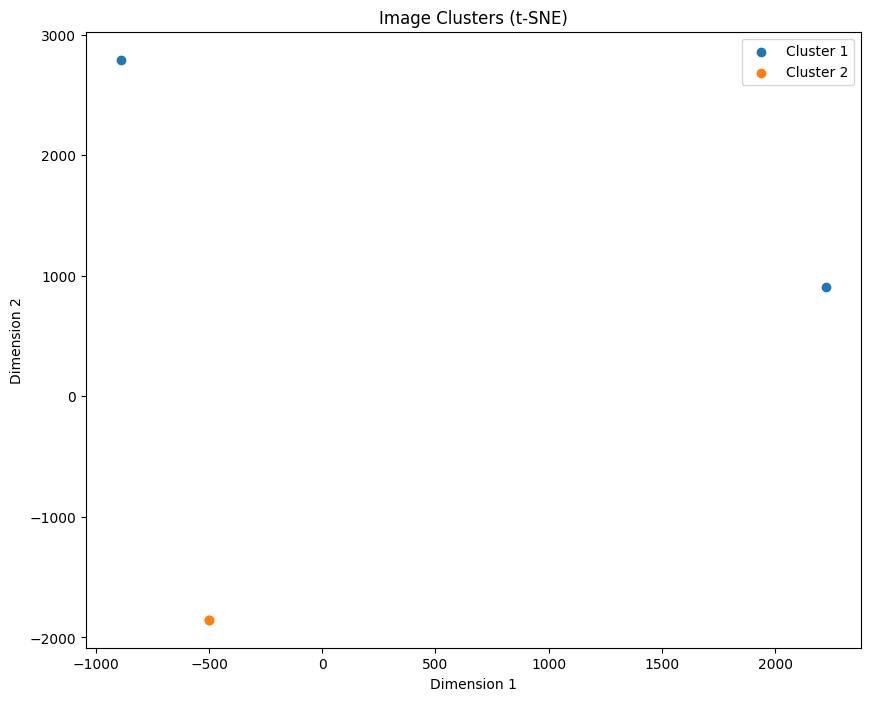

In [ ]:
# Step 8: Visualize Clusters Using t-SNE
# Reduce dimensionality for visualization
tsne = TSNE(n_components=2, perplexity=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Plot the clusters
plt.figure(figsize=(10, 8))
for cluster in range(num_clusters):
    cluster_indices = np.where(labels == cluster)
    plt.scatter(
        reduced_embeddings[cluster_indices, 0],
        reduced_embeddings[cluster_indices, 1],
        label=f"Cluster {cluster + 1}"
    )
plt.title("Image Clusters (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()



In [ ]:
# Step 9: Print Cluster Assignments
for cluster in range(num_clusters):
    print(f"Cluster {cluster + 1}:")
    for idx, url in enumerate(image_urls):
        if labels[idx] == cluster:
            print(f"  - {url}")
    print()

Cluster 1:
  - https://upload.wikimedia.org/wikipedia/commons/4/47/PNG_transparency_demonstration_1.png
  - https://upload.wikimedia.org/wikipedia/commons/a/a9/Example.jpg

Cluster 2:
  - https://upload.wikimedia.org/wikipedia/commons/3/3f/JPEG_example_JPG_RIP_100.jpg
  - https://upload.wikimedia.org/wikipedia/commons/9/96/Example.png

